# Imports and setup

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration
DB_FILE = os.path.join("data", "processed", "warehouse.db")

# Setup Plotting
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def get_conn():
    return sqlite3.connect(DB_FILE)

# Reaction by breed


Top 20 Breed-Reaction pairs:


,breed,reaction_term,count
0,Crossbred Canine/Dog,Vomiting,27
1,Labrador Retriever,Vomiting,26
2,Labrador Retriever,"INEFFECTIVE, HEARTWORM LARVAE",21
3,Crossbred Canine/Dog,"INEFFECTIVE, HEARTWORM LARVAE",18
4,Labrador Retriever,Lack of efficacy (endoparasite) - heartworm,13
5,Chihuahua,Vomiting,12
6,Labrador Retriever,Anorexia,12
7,Golden Retriever,Vomiting,11
8,Dog (Unknown),Vomiting,9
9,Labrador Retriever,Emesis,9


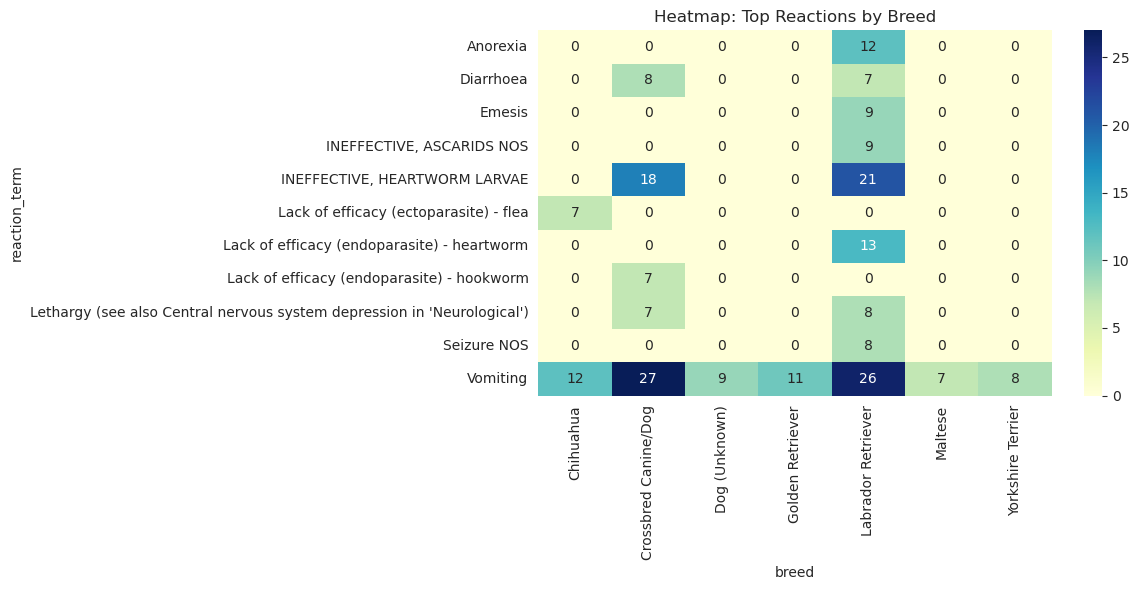

In [5]:
conn = get_conn()
query = """
SELECT
    a.breed,
    r.reaction_term,
    COUNT(DISTINCT f.event_id) as count
FROM fact_analysis f
JOIN dim_animal a ON f.animal_key = a.animal_key
JOIN dim_reaction r ON f.reaction_key = r.reaction_key
WHERE a.breed IS NOT NULL
  AND a.breed != 'Unknown'
  AND a.breed != 'Mixed Breed'
GROUP BY a.breed, r.reaction_term
ORDER BY count DESC
LIMIT 20
"""
df_reactions = pd.read_sql_query(query, conn)
conn.close()

print("Top 20 Breed-Reaction pairs:")
display(df_reactions)

if not df_reactions.empty:
    # Pivot the data: Rows=Reaction, Cols=Breed, Values=Count
    pivot_df = df_reactions.pivot(index='reaction_term', columns='breed', values='count').fillna(0)

    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap='YlGnBu')
    plt.title('Heatmap: Top Reactions by Breed')
    plt.tight_layout()
    plt.show()
else:
    print("No data found for reactions.")

# Active Ingredients

Top 10 Active Ingredients (by Number of Events):


,active_ingredient,count
0,Spinosad,190
1,Milbemycin Oxime,179
2,Ivermectin,93
3,Pyrantel As Pamoate Salt,69
4,Moxidectin,58
5,Afoxolaner,45
6,Fluralaner Chew Tablets,38
7,Pyrantel Pamoate;Sarolaner,33
8,Praziquantel,33
9,Carprofen,33


/tmp/ipykernel_43388/2968283291.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ingredients, x='count', y='active_ingredient', palette='viridis')


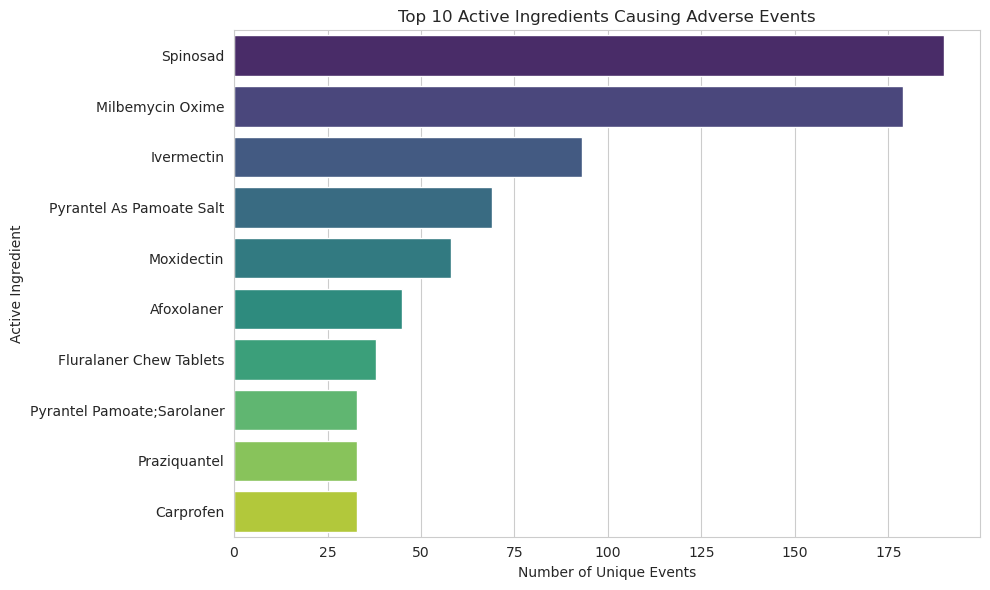

In [6]:
conn = get_conn()
query = """
SELECT
    d.active_ingredient,
    COUNT(DISTINCT f.event_id) as count
FROM fact_analysis f
JOIN dim_drug d ON f.drug_key = d.drug_key
WHERE d.active_ingredient IS NOT NULL
GROUP BY d.active_ingredient
ORDER BY count DESC
LIMIT 10
"""
df_ingredients = pd.read_sql_query(query, conn)
conn.close()

print("Top 10 Active Ingredients (by Number of Events):")
display(df_ingredients)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_ingredients, x='count', y='active_ingredient', palette='viridis')
plt.title('Top 10 Active Ingredients Causing Adverse Events')
plt.xlabel('Number of Unique Events')
plt.ylabel('Active Ingredient')
plt.tight_layout()
plt.show()

# Gender and outcome

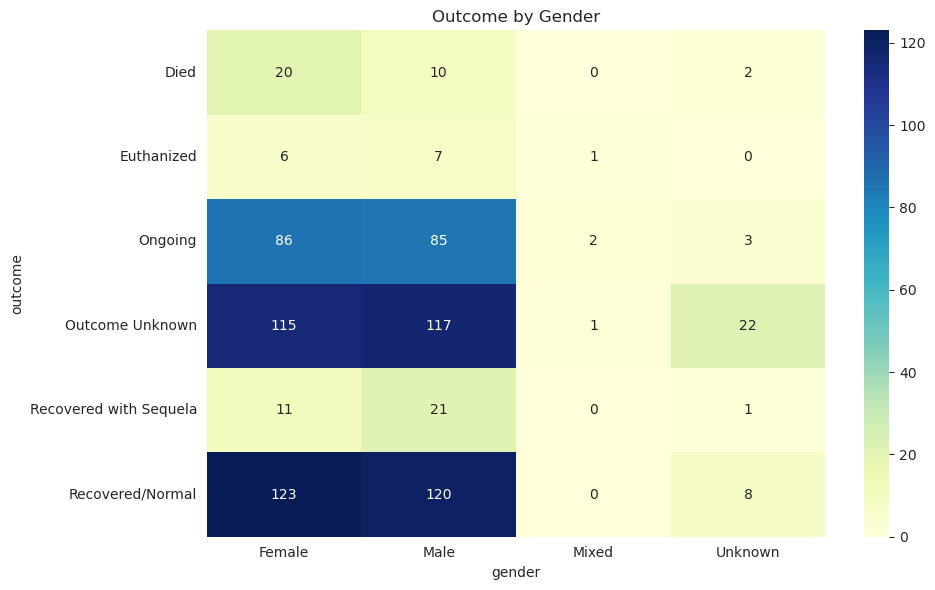

In [7]:
conn = get_conn()
query = """
SELECT
    a.gender,
    f.outcome,
    COUNT(DISTINCT f.event_id) as count
FROM fact_analysis f
JOIN dim_animal a ON f.animal_key = a.animal_key
WHERE a.gender IS NOT NULL
  AND f.outcome IS NOT NULL
  AND f.outcome != 'Unknown'
GROUP BY a.gender, f.outcome
"""
df_gender = pd.read_sql_query(query, conn)
conn.close()

if df_gender.empty:
    print("No data for gender correlation.")
else:
    # Pivot for heatmap
    pivot = df_gender.pivot(index='outcome', columns='gender', values='count').fillna(0)

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='g', cmap='YlGnBu')
    plt.title('Outcome by Gender')
    plt.tight_layout()
    plt.show()

# Days to reaction

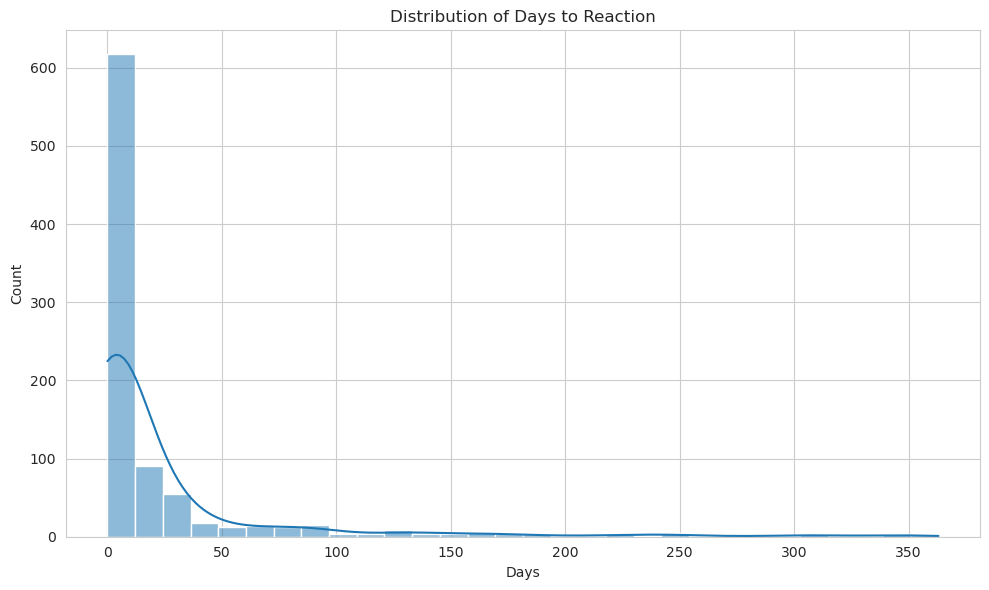

In [8]:
conn = get_conn()
query = """
SELECT days_to_reaction
FROM fact_analysis
WHERE days_to_reaction IS NOT NULL
  AND days_to_reaction >= 0
  AND days_to_reaction < 365
GROUP BY event_id  -- Deduplicate events (since rows are exploded by drug/reaction)
"""
df_days = pd.read_sql_query(query, conn)
conn.close()

if df_days.empty:
    print("No data for days to reaction.")
else:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_days['days_to_reaction'], bins=30, kde=True)
    plt.title('Distribution of Days to Reaction')
    plt.xlabel('Days')
    plt.tight_layout()
    plt.show()

# Breeding Groups Analysis

Top Reactions by Breeding Group:


,breeding_group,reaction_term,count
0,Sporting,Vomiting,39
2,Toy,Vomiting,25
6,Non-Sporting,Vomiting,13
10,Hound,Vomiting,9
14,Herding,Vomiting,8
31,Working,Vomiting,6
82,Terrier,Vomiting,3
8,Sporting,Lethargy (see also Central nervous system depr...,10
13,Toy,Lethargy (see also Central nervous system depr...,9
32,Herding,Lethargy (see also Central nervous system depr...,5


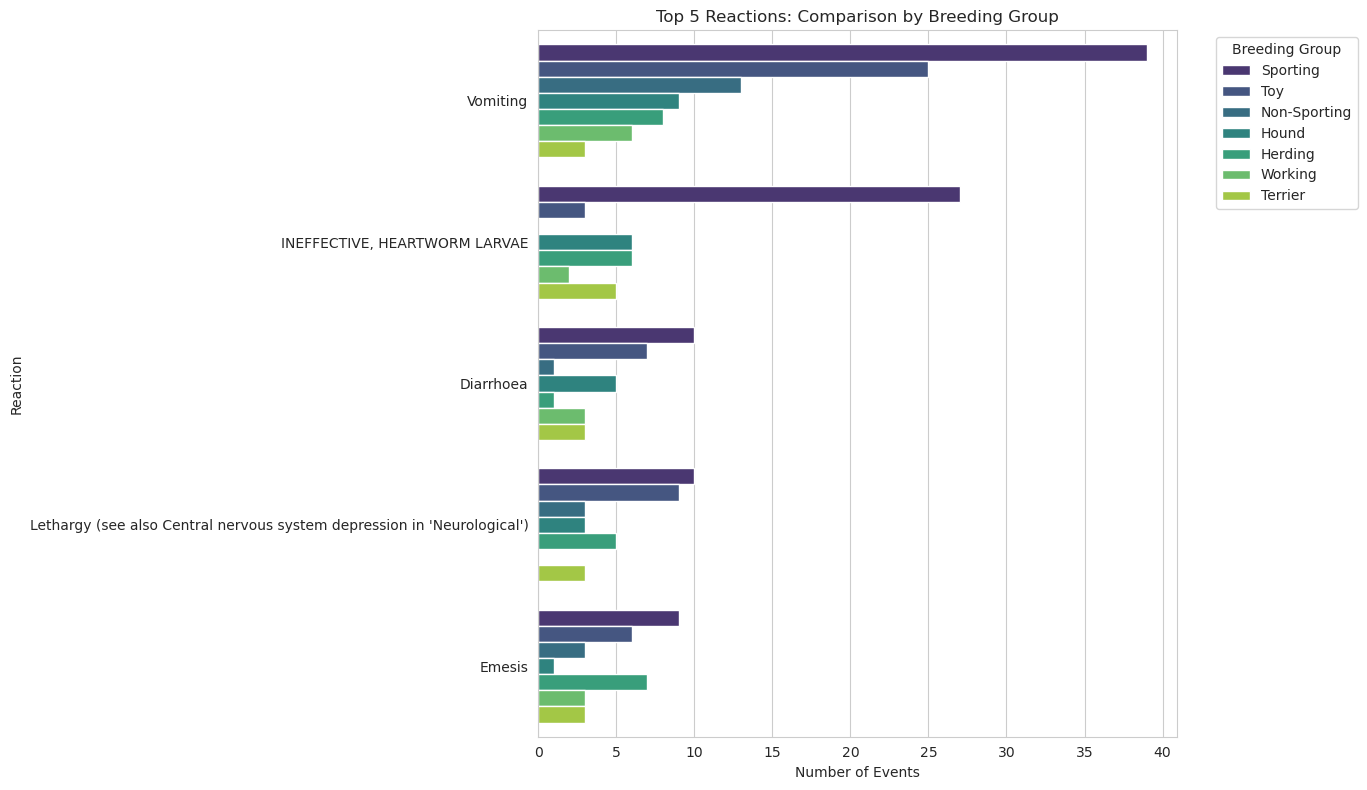

In [9]:
conn = get_conn()

# 1. Fetch Data
query = """
SELECT
    a.breeding_group,
    r.reaction_term,
    COUNT(DISTINCT f.event_id) as count
FROM fact_analysis f
JOIN dim_animal a ON f.animal_key = a.animal_key
JOIN dim_reaction r ON f.reaction_key = r.reaction_key
WHERE a.breeding_group IS NOT NULL
  AND a.breeding_group != 'Unknown'
  AND a.breeding_group != 'None'
GROUP BY a.breeding_group, r.reaction_term
ORDER BY count DESC
"""
df_breeding = pd.read_sql_query(query, conn)
conn.close()

# 2. Filter for a cleaner plot (Top 5 Reactions only)
if not df_breeding.empty:
    top_reactions = df_breeding.groupby('reaction_term')['count'].sum().nlargest(5).index
    filtered_df = df_breeding[df_breeding['reaction_term'].isin(top_reactions)]

    print("Top Reactions by Breeding Group:")
    display(filtered_df.sort_values(['reaction_term', 'count'], ascending=False).head(10))

    plt.figure(figsize=(14, 8))
    # dodge=True makes the bars stand side-by-side
    sns.barplot(
        data=filtered_df,
        x='count',
        y='reaction_term',
        hue='breeding_group',
        dodge=True,
        palette='viridis'
    )

    plt.title('Top 5 Reactions: Comparison by Breeding Group')
    plt.xlabel('Number of Events')
    plt.ylabel('Reaction')
    plt.legend(title='Breeding Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to plot.")